In [2]:
import pandas as pd
import pyarrow
from dotenv import load_dotenv
import os
import re
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.preprocessing import OneHotEncoder
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import pandas as pd
from shapely import wkt
from shapely.affinity import translate, scale
from PIL import Image, ImageDraw

load_dotenv()

file_path = '../../Desktop/Matrix/DATA/'

df_sample = pd.read_parquet(file_path + "detailed_woning_type_sample.parquet")
df = pd.read_csv(file_path + "bag_image_summary.csv", dtype="string")
df_joined = pd.merge(df_sample, df, how="left", right_on="bag_id", left_on="bag_nummeraanduidingid")
df_sample_with_urls = df_joined[df_joined["frontview_exists"].notna()]

# If you want to add the file path to the URLs, set this to True
add_file_path_to_urls = False

# Currently a funda sourced Url goes from: 
# frontview/0797/2000/0002/3888/0797200000023888.jpg
# to: img_dataset/07/079720000002-funda.jpg
def extract_path(url, source):
    if pd.isna(url) or url == '' or url is None:
        return ''
    id = url.rstrip('/').split('/')[-1]
    id, *_ = id.split('.')
    m = re.match(r'(\d{2})', id)
    first_two_digits = m.group(1) if m else ''
    return f"img_dataset/{first_two_digits}/{id}-{source}.jpg"

link_cols = ['frontview_funda_url', 'frontview_google_url', 'frontview_funda_in_business_url']
link_sources = ['funda', 'google', 'funda-in-business'] # Sources are in file name, so need to be added to filename for correct name

for col, source in zip(link_cols, link_sources):
    df_sample_with_urls[f'{col}_split'] = df_sample_with_urls[col].map(lambda url: extract_path(url, source))

# If you want to add the file path to the URLs, set add_file_path_to_urls to True
if add_file_path_to_urls:
    df_sample_with_urls[[f'{col}_split' for col in link_cols]] = df_sample_with_urls[[f'{col}_split' for col in link_cols]].map(lambda x: file_path + x if x else '')
    add_file_path_to_urls = False

df_sample_with_urls.to_csv(
    file_path + "Full_preprocessed_detailed_house.csv",
    index=False,
    encoding='utf-8',
)

df = pd.read_csv(file_path + "Full_preprocessed_detailed_house.csv", dtype="string")

# Verschillend is a special case, so we remove it from the dataset
df = df[df['build_type'] != 'Verschillend']

def pick_first_url(row):
    for col in [f"{c}_split" for c in link_cols]:
        val = row[col]
        if pd.notna(val) and val != '':
            return val
    return ''

df['frontview_url'] = df.apply(pick_first_url, axis=1)
df = df[df['frontview_url'] != '']

# Ensure 'opp_pand' and 'oppervlakte' are numeric before division
df['procent_ingenomen'] = pd.to_numeric(df['opp_pand'], errors='coerce') / pd.to_numeric(df['oppervlakte'], errors='coerce')

df['huisnr_bag_letter'] = df['huisnr_bag_letter'].notna().astype(int)
df['huisnr_bag_toevoeging'] = df['huisnr_bag_toevoeging'].notna().astype(int)

df['is_monument'] = df['is_monument'].fillna(0).astype(int)
df['is_protected'] = df['is_protected'].fillna(0).astype(int)

df = df.drop(columns=['bag_nummeraanduidingid', 'frontview_exists', 'random_rank', 'num_funda_images',
                      'frontview_funda_url', 'frontview_google_url', 'frontview_funda_in_business_url', 
                      'frontview_funda_url_split', 'frontview_google_url_split', 'frontview_funda_in_business_url_split',
                      'special_house_type', 'source_data_result_id',
                      'straatnaam', 'postcode', 'plaatsnaam', 'source_data_timestamp', 'bag_id', 'frontview_url', 'oppervlakte'
                      ])

# Oversample corriderflat door random te dupliceren
merge_map = {
    'Bovenwoning': 'Bovenwoning/Benedenwoning/Maisonette',
    'Benedenwoning': 'Bovenwoning/Benedenwoning/Maisonette',
    'Maisonnette': 'Bovenwoning/Benedenwoning/Maisonette',
    'Corridorflat': 'Corridorflat/Galerijflat',
    'Galerijflat': 'Corridorflat/Galerijflat',
    'Hoekwoning': 'Hoekwoning/Eindwoning',
    'Eindwoning': 'Hoekwoning/Eindwoning',
    'Portiekflat': 'Portiekflat/Portiekwoning',
    'Portiekwoning': 'Portiekflat/Portiekwoning'

    # etc.
}

df['woningtype'] = df['woningtype'].map(merge_map).fillna(df['woningtype'])

# Group by woningtype and sample up to 500 rows per group


# Full preprocessed dataset with URLS, can be loaded into pipeline.
df.to_csv(
    file_path + "Full_preprocessed_detailed_house.csv",
    index=False,
    encoding='utf-8',
)

In [3]:
def compute_orientation(polygon):
    if polygon.is_empty or not polygon.is_valid:
        return np.nan

    # Get minimum rotated rectangle
    mrr = polygon.minimum_rotated_rectangle
    coords = list(mrr.exterior.coords)

    # Find the longest edge
    max_length = 0
    angle = 0

    for i in range(len(coords) - 1):
        p1 = coords[i]
        p2 = coords[i + 1]

        dx = p2[0] - p1[0]
        dy = p2[1] - p1[1]

        length = np.hypot(dx, dy)
        if length > max_length:
            max_length = length
            angle = np.degrees(np.arctan2(dy, dx))

    # Normalize angle to 0–180
    return angle % 180

def compute_elongation(polygon):
    if polygon.is_empty or not polygon.is_valid:
        return np.nan

    # Minimum rotated rectangle (oriented bounding box)
    min_rect = polygon.minimum_rotated_rectangle

    # Get corner points of the box
    coords = list(min_rect.exterior.coords)

    # Compute distances between the 4 sides
    edge_lengths = [np.linalg.norm(np.subtract(coords[i], coords[i + 1])) for i in range(4)]

    width = min(edge_lengths)
    height = max(edge_lengths)

    if height == 0:  # Prevent divide-by-zero
        return np.nan

    return width / height

def rasterize_polygon(geom, size=224):
    bounds = geom.bounds
    geom = translate(geom, xoff=-bounds[0], yoff=-bounds[1])
    scale_x = size / (bounds[2] - bounds[0] + 1e-8)
    scale_y = size / (bounds[3] - bounds[1] + 1e-8)
    geom = scale(geom, xfact=scale_x, yfact=scale_y, origin=(0, 0))

    img = Image.new("L", (size, size), 0)
    draw = ImageDraw.Draw(img)
    coords = [(x, size - y) for x, y in geom.exterior.coords]
    draw.polygon(coords, outline=1, fill=1)
    return np.array(img)

In [4]:
df['geometry_wkt'] = df['geometry'].apply(wkt.loads)

df['centroid_x'] = df['geometry_wkt'].apply(lambda geom: geom.centroid.x)
df['centroid_y'] = df['geometry_wkt'].apply(lambda geom: geom.centroid.y)

df['area'] = df['geometry_wkt'].apply(lambda geom: geom.area)

# perimeter = Sum of the lengths of all edges forming the boundary of a polygon
df['perimeter'] = df['geometry_wkt'].apply(lambda g: g.length)

# Gives 1 for a perfect circle (most compact shape)
# Gets closer to 0 for long, skinny, jagged shapes
df['compactness'] = (
    4 * np.pi * df['area'] / (df['perimeter'] ** 2)
)

df['num_vertices'] = df['geometry_wkt'].apply(lambda g: len(g.exterior.coords))

df['elongation'] = df['geometry_wkt'].apply(compute_elongation)

df['orientation_deg'] = df['geometry_wkt'].apply(compute_orientation)

df['num_vertices_log'] = np.log1p(df['num_vertices'])

df.drop(columns=["geometry", "geometry_wkt"], inplace=True)


df.to_csv(
    file_path + "Full_preprocessed_detailed_house.csv",
    index=False,
    encoding='utf-8',
)

train_df, temp_df = train_test_split(df, test_size=0.4, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

In [5]:


features = [
    'huisnr',                                   # 0 - inf
    'huisnr_bag_letter',                        # 0 - 1
    'huisnr_bag_toevoeging',                    # 0 - 1
    'opp_pand',                                 # StandardScaler
    'oppervlakte',                              # StandardScaler
    'build_year',                               # StandardScaler
    'build_type_Appartement',                   # OneHotEncoder
    'build_type_Hoekwoning',                    # OneHotEncoder
    'build_type_Tussen_of_geschakelde_woning',   # OneHotEncoder
    'build_type_Tweeonder1kap',                 # OneHotEncoder
    'build_type_Verschillend',                  # OneHotEncoder
    'is_monument',                              # 0 - 1
    'is_protected',                             # 0 - 1
    'procent_ingenomen'                         # 0 - 1
]

target = 'woningtype'



In [6]:

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
train_df, temp_df = train_test_split(df, test_size=0.4, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        



numeric_cols = ['opp_pand', 'build_year', 'huisnr', 'procent_ingenomen']

scaler = StandardScaler()
train_df[numeric_cols] = scaler.fit_transform(train_df[numeric_cols])
val_df[numeric_cols] = scaler.transform(val_df[numeric_cols])
test_df[numeric_cols] = scaler.transform(test_df[numeric_cols])


for col in ['centroid_x', 'centroid_y']:
    min_val = train_df[col].min()
    max_val = train_df[col].max()
    for df in [train_df, val_df, test_df]:
        df[col] = (df[col] - min_val) / (max_val - min_val + 1e-8)

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoder.fit(train_df[['build_type']])
feature_names = [name.replace(' ', '_') for name in encoder.get_feature_names_out(['build_type'])]

for df in [train_df, val_df, test_df]:
    encoded_array = encoder.transform(df[['build_type']])
    encoded_df = pd.DataFrame(encoded_array, columns=feature_names, index=df.index)
    df.drop(columns='build_type', inplace=True)
    df[encoded_df.columns] = encoded_df



X_train = train_df.drop(columns=["woningtype"])
print(X_train.dtypes)



huisnr                                     float64
huisnr_bag_letter                            int64
huisnr_bag_toevoeging                        int64
opp_pand                                   float64
build_year                                 float64
is_monument                                  int64
is_protected                                 int64
procent_ingenomen                          float64
centroid_x                                 float64
centroid_y                                 float64
area                                       float64
perimeter                                  float64
compactness                                float64
num_vertices                                 int64
elongation                                 float64
orientation_deg                            float64
num_vertices_log                           float64
build_type_Appartement                     float64
build_type_Hoekwoning                      float64
build_type_Tussen_of_geschakeld

In [7]:


#classical naive bayas probability model for baseline

from sklearn.naive_bayes import GaussianNB, CategoricalNB
# Suppose 'col_name' is your column with number-strings

X_train = train_df.drop(columns=["woningtype"])
y_train = train_df["woningtype"]

X_val = val_df.drop(columns=["woningtype"])
y_val = val_df["woningtype"]

X_test = test_df.drop(columns=["woningtype"])
y_test = test_df["woningtype"]

#wow moeilijke code (niet)
#guassian NB ipv categorical omdat onze data niet alleen categorical is (WOW)
NB = GaussianNB()
NB.fit(X_train, y_train)
from sklearn.metrics import (
        accuracy_score, precision_score, recall_score, f1_score,
        log_loss, cohen_kappa_score, 
    )

y_pred = NB.predict(X_val)
y_proba = NB.predict_proba(X_val)
    
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='macro', zero_division=0)
recall = recall_score(y_val, y_pred, average='macro', zero_division=0)
f1 = f1_score(y_val, y_pred, average='macro', zero_division=0)
kappa = cohen_kappa_score(y_val, y_pred)
logloss = log_loss(y_val, y_proba)
    
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (macro): {precision:.4f}")
print(f"Recall (macro): {recall:.4f}")
print(f"F1 Score (macro): {f1:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")
print(f"Log Loss: {logloss:.4f}")


Accuracy: 0.4823
Precision (macro): 0.5074
Recall (macro): 0.4803
F1 Score (macro): 0.4453
Cohen's Kappa: 0.4134
Log Loss: 3.1497


Accuracy: 0.6544
Precision (macro): 0.6389
Recall (macro): 0.6424
F1 Score (macro): 0.6338
Cohen's Kappa: 0.4134
Log Loss: 1.1400


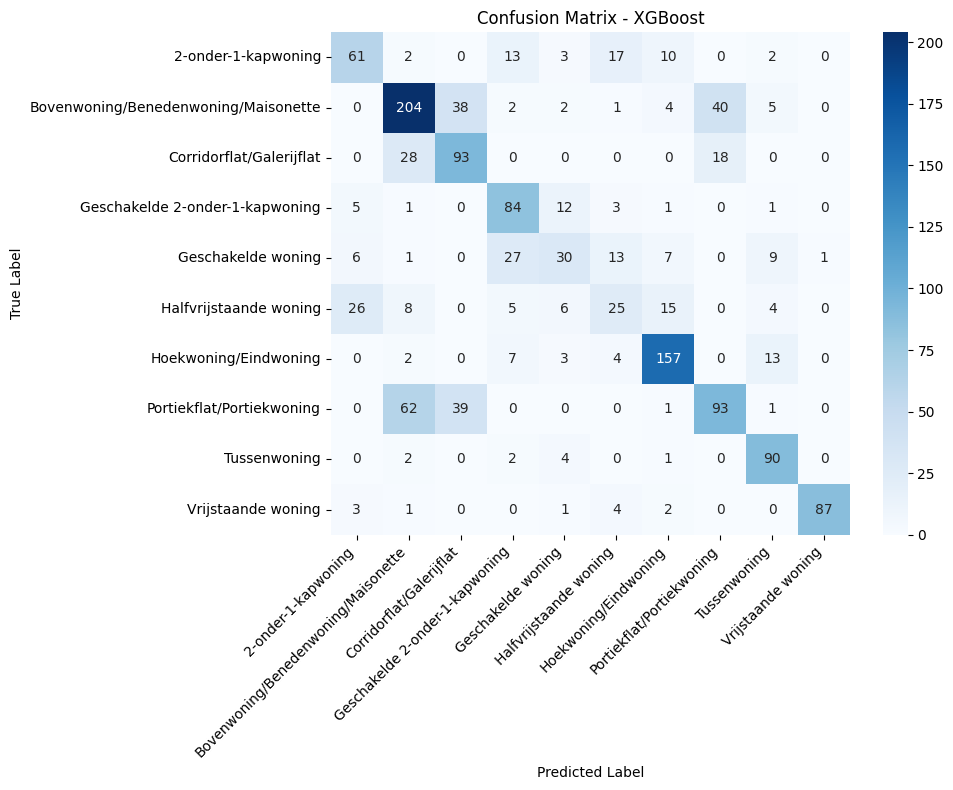

In [10]:


#discriminitive classical model (probabky xgboost or random forest)
#random forest is denk beter als deze modellen alleen als baseline worden gebruikt
#xg is meer accurate tho
#heb de categorical features niet geencode want dacht dat koen dat al gedaan had? anders ga ik er nog achteraan

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from imblearn.over_sampling import SMOTE

X_train = train_df.drop(columns=["woningtype"])
y_train = train_df["woningtype"]



X_train = train_df.drop(columns=["woningtype"])
y_train = train_df["woningtype"]

X_val = val_df.drop(columns=["woningtype"])
y_val = val_df["woningtype"]

X_test = test_df.drop(columns=["woningtype"])
y_test = test_df["woningtype"]

#random forest is minder accuraat maar meer interpeteerbaar en minder complex
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)

#accurater maar moet ff meer hyperparamter tuningg doen
y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)
    
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
logloss = log_loss(y_test, y_proba)
    
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (macro): {precision:.4f}")
print(f"Recall (macro): {recall:.4f}")
print(f"F1 Score (macro): {f1:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")
print(f"Log Loss: {logloss:.4f}")

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Predict again if needed (already done earlier)
y_pred_xgb = rf.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_xgb)

# Get class names back from the LabelEncoder
labels = rf.classes_ 

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [95]:
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, log_loss

# Encode the labels
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)
y_test_enc = le.transform(y_test)

# Train XGBoost
xgb_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='mlogloss',
    random_state=42
)

xgb_model.fit(X_train, y_train_enc)

# Predict
y_pred_xgb = xgb_model.predict(X_test)
y_proba_xgb = xgb_model.predict_proba(X_test)
# Convert integer predictions back to original labels
y_pred_labels = le.inverse_transform(y_pred_xgb)

# Evaluate
accuracy_xgb = accuracy_score(y_test_enc, y_pred_xgb)
precision_xgb = precision_score(y_test_enc, y_pred_xgb, average='macro', zero_division=0)
recall_xgb = recall_score(y_test_enc, y_pred_xgb, average='macro', zero_division=0)
f1_xgb = f1_score(y_test_enc, y_pred_xgb, average='macro', zero_division=0)
kappa_xgb = cohen_kappa_score(y_val_enc, xgb_model.predict(X_val))
logloss_xgb = log_loss(y_test_enc, y_proba_xgb)

# Print
print("\n--- XGBoost Results (Encoded Labels) ---")
print(f"Accuracy: {accuracy_xgb:.4f}")
print(f"Precision (macro): {precision_xgb:.4f}")
print(f"Recall (macro): {recall_xgb:.4f}")
print(f"F1 Score (macro): {f1_xgb:.4f}")
print(f"Cohen's Kappa: {kappa_xgb:.4f}")
print(f"Log Loss: {logloss_xgb:.4f}")





--- XGBoost Results (Encoded Labels) ---
Accuracy: 0.6501
Precision (macro): 0.6424
Recall (macro): 0.6500
F1 Score (macro): 0.6424
Cohen's Kappa: 0.5854
Log Loss: 0.9604


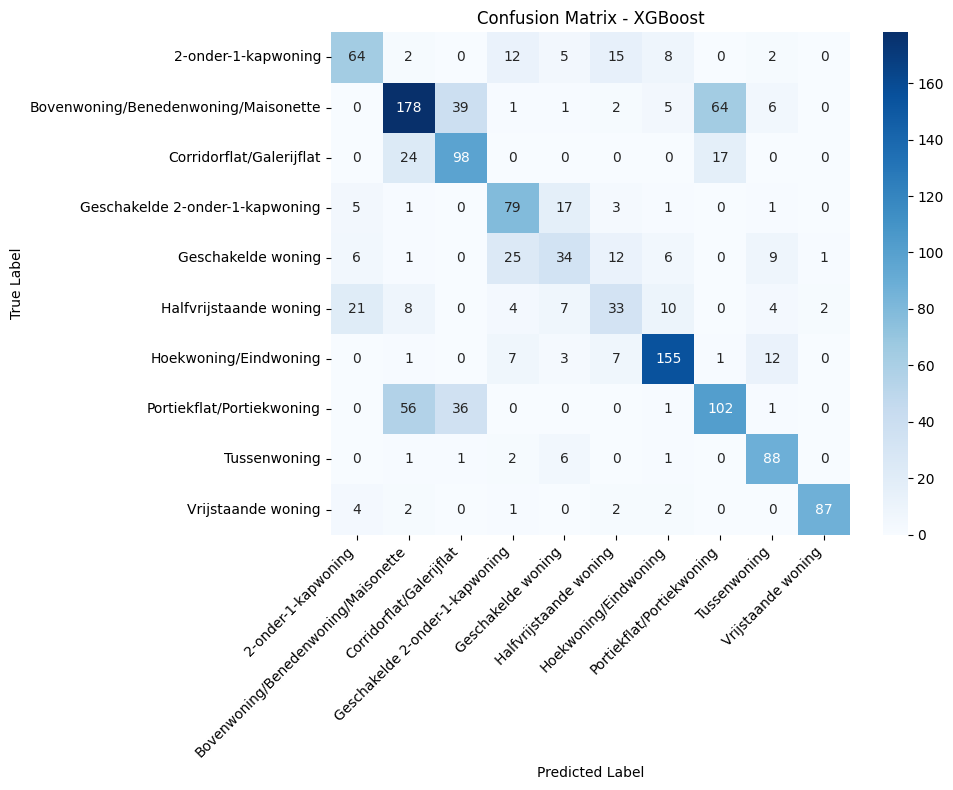

In [96]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Predict again if needed (already done earlier)
y_pred_xgb = xgb_model.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test_enc, y_pred_xgb)

# Get class names back from the LabelEncoder
labels = le.classes_

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()
